In [17]:
import geopandas as gpd
import geopy
import requests
import json
import rasterio as rs
import rioxarray 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline


In [4]:
addr = "Spijker 27, 2910 Essen"
loc = gpd.tools.geocode(addr)
loc

,geometry,address
0,POINT (4.47514 51.45742),"27, Spijker, 2910, Spijker, Essen, Antwerpen, ..."


In [5]:
address =  "Spijker 27, 2910 Essen"

In [6]:
def get_details(address: str):
    req = requests.get(f"https://loc.geopunt.be/v4/Location?q={address}").json()
    info = {'address' : address, 
                'x_value' : req['LocationResult'][0]['Location']['X_Lambert72'],
                'y_value' : req['LocationResult'][0]['Location']['Y_Lambert72'],
                'street' : req['LocationResult'][0]['Thoroughfarename'],
                'house_number' : req['LocationResult'][0]['Housenumber'], 
                'postcode': req['LocationResult'][0]['Zipcode'], 
                'municipality' : req['LocationResult'][0]['Municipality']}
    
    detail = requests.get("https://api.basisregisters.vlaanderen.be/v1/adresmatch", 
                          params={"postcode": info['postcode'], 
                                  "straatnaam": info['street'],
                                  "huisnummer": info['house_number']}).json()
    building = requests.get(detail['adresMatches'][0]['adresseerbareObjecten'][0]['detail']).json()
    build = requests.get(building['gebouw']['detail']).json()
    info['polygon'] = [build['geometriePolygoon']['polygon']['coordinates']]
    
    return info

In [7]:
info = get_details(address)
info


{'address': 'Spijker 27, 2910 Essen',
 'x_value': 157393.98,
 'y_value': 238649.05,
 'street': 'Spijker',
 'house_number': '27',
 'postcode': '2910',
 'municipality': 'Essen',
 'polygon': [[[[157395.55195236206, 238645.81296755746],
    [157395.55041636527, 238647.40183155984],
    [157403.5940643698, 238647.57475956157],
    [157403.59035237134, 238651.458151564],
    [157403.5900963694, 238651.72547956184],
    [157385.9729443565, 238651.76995956153],
    [157385.97332835943, 238651.3299595639],
    [157385.97883235663, 238645.52637555823],
    [157395.55195236206, 238645.81296755746]]]]}

In [8]:
polygon = info["polygon"]
polygon

[[[[157395.55195236206, 238645.81296755746],
   [157395.55041636527, 238647.40183155984],
   [157403.5940643698, 238647.57475956157],
   [157403.59035237134, 238651.458151564],
   [157403.5900963694, 238651.72547956184],
   [157385.9729443565, 238651.76995956153],
   [157385.97332835943, 238651.3299595639],
   [157385.97883235663, 238645.52637555823],
   [157395.55195236206, 238645.81296755746]]]]

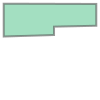

In [9]:
from shapely import geometry

poly = geometry.Polygon(polygon[0][0])
poly

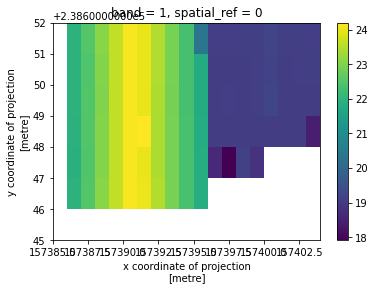

In [12]:
clipped = [ {'type': 'Polygon','coordinates': polygon[0]}]
dsm = rioxarray.open_rasterio('DSM_k01.tif', masked =True).rio.clip(clipped, from_disk=True)
dsm.plot()

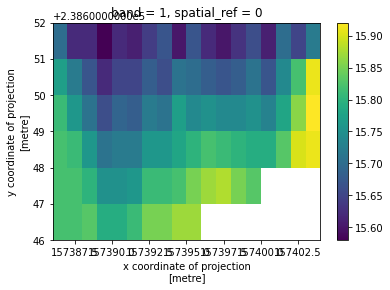

In [13]:
dtm = rioxarray.open_rasterio('DTM_k01.tif',masked=True).rio.clip(clipped)

dtm.plot()

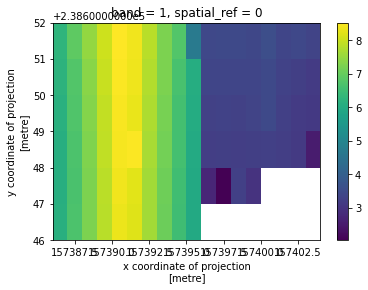

In [14]:
clipped_chm = dsm - dtm 
clipped_chm.plot()

In [21]:
chm = clipped_chm[0]
chm.shape


(6, 18)

/tmp/ipykernel_4939/2410645451.py:8: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  chm3d = ax.plot_surface(x1, y1, chm)


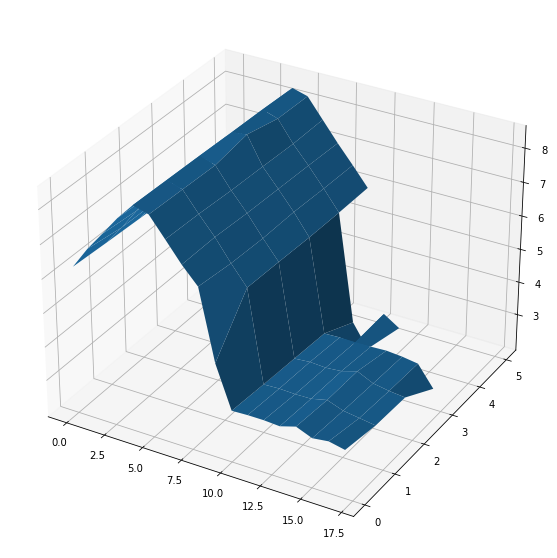

In [22]:
ny = chm.shape[0]
nx = chm.shape[1]
x = range(nx)
y = range(ny)
x1, y1 = np.meshgrid(x, y)
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
chm3d = ax.plot_surface(x1, y1, chm)

plt.show()